In [6]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers
from sionna.channel import ApplyOFDMChannel
from sionna.channel.tr38901 import AntennaArray, CDL
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper, SymbolDemapper
from sionna.utils import BinarySource, ebnodb2no, compute_ber, compute_ser
import sionna

# Set random seed for reproducibility
sionna.config.seed = 42

# Global results dictionary
model_results = {}

def log_model_results(model_name, ser_value, loss_history=None):
    model_results[model_name] = {'SER': ser_value, 'loss_history': loss_history}
    print(f"[LOG] Saved results for {model_name}: SER={ser_value:.6f}")

# ========================
# System Parameters
# ========================
num_ut = 1
num_bs = 1
num_ut_ant = 4
num_bs_ant = 8
num_streams_per_tx = num_ut_ant
rx_tx_association = np.array([[1]])
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=76,
                  subcarrier_spacing=15e3,
                  num_tx=1,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=6,
                  num_guard_carriers=[5,6],
                  dc_null=True,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2,11])

carrier_frequency = 2.6e9
ut_array = AntennaArray(num_rows=1, num_cols=int(num_ut_ant/2),
                        polarization="dual", polarization_type="cross",
                        antenna_pattern="38.901", carrier_frequency=carrier_frequency)
bs_array = AntennaArray(num_rows=1, num_cols=int(num_bs_ant/2),
                        polarization="dual", polarization_type="cross",
                        antenna_pattern="38.901", carrier_frequency=carrier_frequency)

delay_spread = 300e-9
cdl_model = "B"
speed = 10
direction = "uplink"
cdl = CDL(cdl_model, delay_spread, carrier_frequency, ut_array, bs_array, direction, min_speed=speed)

num_bits_per_symbol = 4  # 16-QAM
coderate = 0.5
n = int(rg.num_data_symbols * num_bits_per_symbol)
k = int(n * coderate)

binary_source = BinarySource()
encoder = LDPC5GEncoder(k, n)
decoder = LDPC5GDecoder(encoder, hard_out=True)
mapper = Mapper("qam", num_bits_per_symbol)
demapper = Demapper("app", "qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(rg)
ls_est = LSChannelEstimator(rg, interpolation_type="nn")
lmmse_equ = LMMSEEqualizer(rg, sm)
remove_nulled_scs = RemoveNulledSubcarriers(rg)
channel_freq = ApplyOFDMChannel(add_awgn=True)

# ========================
# Helper Functions
# ========================
def bits_to_symbol_indices(bits_tensor, bits_per_symbol):
    bits_flat = tf.reshape(bits_tensor, [-1])
    bits_grouped = tf.reshape(bits_flat, [-1, bits_per_symbol])
    bits_grouped_int = tf.cast(bits_grouped, tf.int32)
    powers = 2 ** tf.range(bits_per_symbol - 1, -1, -1, dtype=tf.int32)
    symbol_indices = tf.reduce_sum(bits_grouped_int * powers, axis=1)
    return symbol_indices

def symbol_indices_to_bits(indices, bits_per_symbol=4):
    indices = tf.cast(indices, tf.int64)
    powers = 2 ** tf.range(bits_per_symbol - 1, -1, -1, dtype=tf.int64)
    bits = tf.bitwise.bitwise_and(tf.expand_dims(indices, -1) // powers, 1)
    return tf.cast(tf.reshape(bits, [-1]), tf.float32)

# ========================
# Model Definitions
# ========================
class ESNSingleStep(tf.keras.Model):
    def __init__(self, reservoir_size=600, input_size=2, output_size=16, spectral_radius=0.8, dropout_rate=0.1, l2_lambda=1e-4):
        super().__init__()
        self.reservoir_size = reservoir_size
        self.input_size = input_size
        self.output_size = output_size
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.W_in = tf.Variable(tf.random.uniform((input_size, reservoir_size), -0.1, 0.1), trainable=False)
        W_res_init = tf.random.uniform((reservoir_size, reservoir_size), -0.5, 0.5)
        max_eig = tf.reduce_max(tf.abs(tf.linalg.eigvals(W_res_init)))
        self.W_res = tf.Variable(W_res_init * (spectral_radius / max_eig), trainable=False)
        self.W_out = tf.Variable(tf.zeros((reservoir_size, output_size)), trainable=True)
        self.b_out = tf.Variable(tf.zeros((output_size,)), trainable=True)

    def call(self, inputs, states=None, training=False):
        batch_size = tf.shape(inputs)[0]
        if states is None:
            states = tf.zeros([batch_size, self.reservoir_size], dtype=inputs.dtype)
        new_state = tf.math.tanh(tf.matmul(inputs, self.W_in) + tf.matmul(states, self.W_res))
        if training:
            new_state = tf.nn.dropout(new_state, rate=self.dropout_rate)
        outputs = tf.matmul(new_state, self.W_out) + self.b_out
        return outputs, new_state

class ESNSingleStepMulti(tf.keras.Model):
    def __init__(self, reservoir_size=600, input_size=2, output_size=16, hidden_units=128, spectral_radius=0.8, dropout_rate=0.1, l2_lambda=1e-4):
        super().__init__()
        self.reservoir_size = reservoir_size
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.W_in = tf.Variable(tf.random.uniform((input_size, reservoir_size), -0.1, 0.1), trainable=False)
        W_res_init = tf.random.uniform((reservoir_size, reservoir_size), -0.5, 0.5)
        max_eig = tf.reduce_max(tf.abs(tf.linalg.eigvals(W_res_init)))
        self.W_res = tf.Variable(W_res_init * (spectral_radius / max_eig), trainable=False)
        self.W_hidden = tf.Variable(tf.random.normal([reservoir_size, hidden_units], stddev=0.1), trainable=True)
        self.b_hidden = tf.Variable(tf.zeros([hidden_units]), trainable=True)
        self.W_out = tf.Variable(tf.random.normal([hidden_units, output_size], stddev=0.1), trainable=True)
        self.b_out = tf.Variable(tf.zeros((output_size,)), trainable=True)

    def call(self, inputs, states=None, training=False):
        batch_size = tf.shape(inputs)[0]
        if states is None:
            states = tf.zeros([batch_size, self.reservoir_size], dtype=inputs.dtype)
        new_state = tf.math.tanh(tf.matmul(inputs, self.W_in) + tf.matmul(states, self.W_res))
        if training:
            new_state = tf.nn.dropout(new_state, rate=self.dropout_rate)
        hidden = tf.nn.relu(tf.matmul(new_state, self.W_hidden) + self.b_hidden)
        if training:
            hidden = tf.nn.dropout(hidden, rate=self.dropout_rate)
        outputs = tf.matmul(hidden, self.W_out) + self.b_out
        return outputs, new_state

def build_simple_fc_16():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(2,)),
        tf.keras.layers.Dense(16)
    ])
    return model

def build_cnn_16():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((2, 1), input_shape=(2,)),
        tf.keras.layers.Conv1D(16, kernel_size=1, activation='relu'),
        tf.keras.layers.Conv1D(16, kernel_size=1, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(16)
    ])
    return model

def build_rnn_16():
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(64, return_sequences=False, input_shape=(1, 2)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(16)
    ])
    return model

class ELM:
    def __init__(self, input_size=2, hidden_size=600, output_size=16):
        self.hidden_size = hidden_size
        self.W_in = np.random.uniform(-1, 1, (input_size, hidden_size)).astype(np.float32)
        self.b_hidden = np.random.uniform(-1, 1, hidden_size).astype(np.float32)
        self.W_out = None

    def fit(self, X, Y):
        H = np.tanh(np.dot(X, self.W_in) + self.b_hidden)
        Y_onehot = tf.keras.utils.to_categorical(Y, num_classes=16)
        self.W_out = np.dot(np.linalg.pinv(H), Y_onehot)

    def predict(self, X):
        H = np.tanh(np.dot(X, self.W_in) + self.b_hidden)
        logits = np.dot(H, self.W_out)
        return logits

# ========================
# Training Functions
# ========================
@tf.function
def train_step_esn(x_in, y_in, model, optimizer):
    with tf.GradientTape() as tape:
        logits, _ = model(x_in, training=True)
        xent_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_in, logits=logits))
        l2_loss = tf.nn.l2_loss(model.W_out)
        total_loss = xent_loss + model.l2_lambda * l2_loss
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss

@tf.function
def train_step_esn_multi(x_in, y_in, model, optimizer):
    with tf.GradientTape() as tape:
        logits, _ = model(x_in, training=True)
        xent_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_in, logits=logits))
        l2_hidden = tf.nn.l2_loss(model.W_hidden)
        l2_out = tf.nn.l2_loss(model.W_out)
        total_loss = xent_loss + model.l2_lambda * (l2_hidden + l2_out)
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss




Simulating Eb/N0 = 0 dB
[LOG] Saved results for ESN_0dB: SER=0.376303
[LOG] Saved results for DeepESN_0dB: SER=0.314786
[LOG] Saved results for FNN_0dB: SER=0.634657
[LOG] Saved results for CNN_0dB: SER=0.495499
[LOG] Saved results for RNN_0dB: SER=0.657723
[LOG] Saved results for ELM_0dB: SER=0.324602

Simulating Eb/N0 = 10 dB
[LOG] Saved results for ESN_10dB: SER=0.051956
[LOG] Saved results for DeepESN_10dB: SER=0.018616
[LOG] Saved results for FNN_10dB: SER=0.083999
[LOG] Saved results for CNN_10dB: SER=0.265780
[LOG] Saved results for RNN_10dB: SER=0.326026
[LOG] Saved results for ELM_10dB: SER=0.017013

Simulating Eb/N0 = 20 dB
[LOG] Saved results for ESN_20dB: SER=0.001475
[LOG] Saved results for DeepESN_20dB: SER=0.000305
[LOG] Saved results for FNN_20dB: SER=0.573114
[LOG] Saved results for CNN_20dB: SER=0.578404
[LOG] Saved results for RNN_20dB: SER=0.375057
[LOG] Saved results for ELM_20dB: SER=0.000127


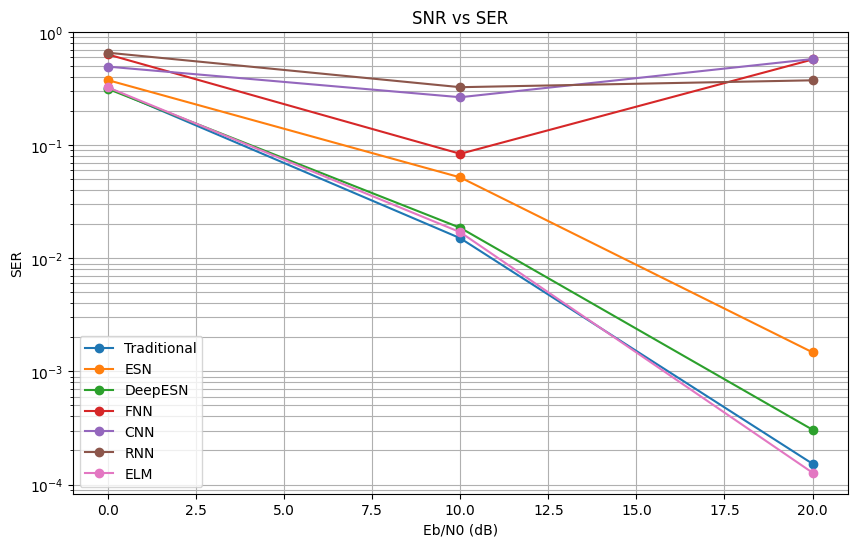

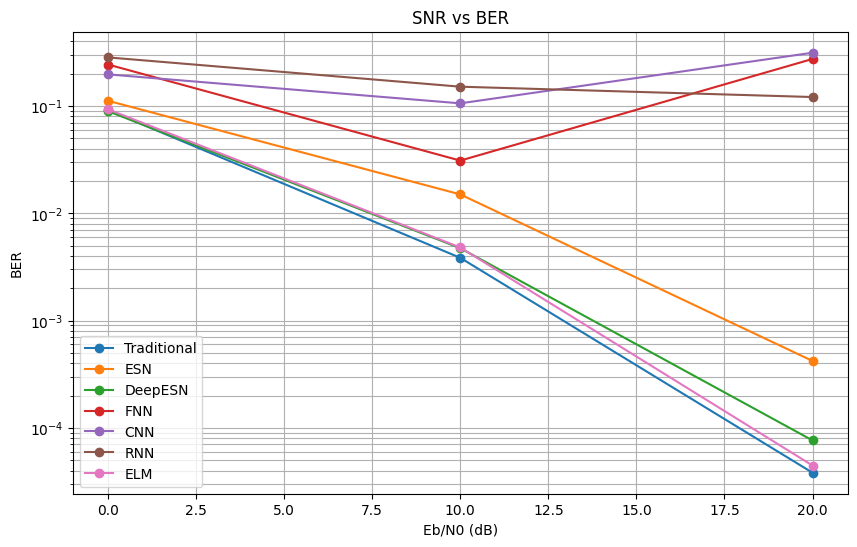

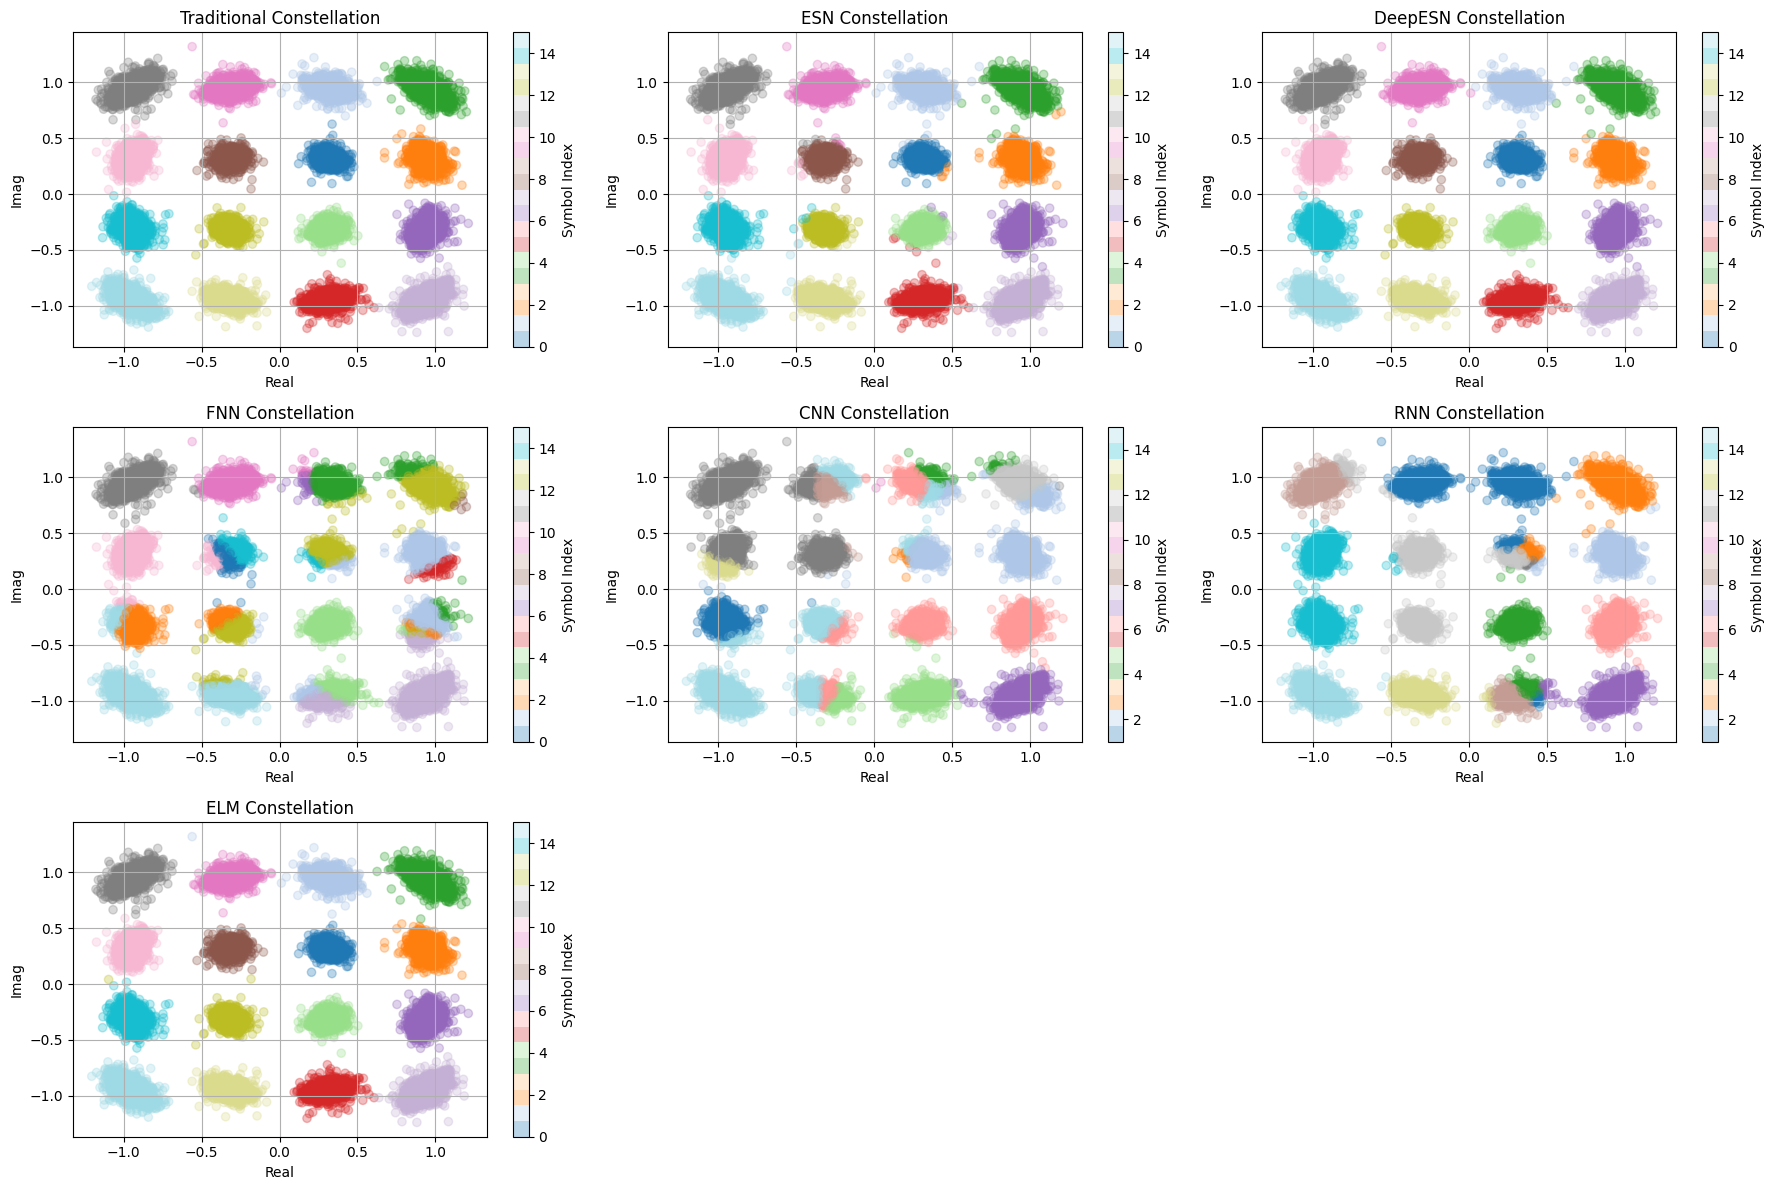

In [7]:
# ========================
# Simulation Over SNR
# ========================
batch_size_sim = 64
ebno_dbs = np.arange(0, 22, 10)
ser_vs_snr = {model: [] for model in ['Traditional', 'ESN', 'DeepESN', 'FNN', 'CNN', 'RNN', 'ELM']}
ber_vs_snr = {model: [] for model in ser_vs_snr.keys()}

for ebno_db in ebno_dbs:
    print(f"\nSimulating Eb/N0 = {ebno_db} dB")
    no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)
    
    # Generate data
    b = binary_source([batch_size_sim, 1, rg.num_streams_per_tx, k])
    c = encoder(b)
    x = mapper(c)
    x_rg = rg_mapper(x)
    cir = cdl(batch_size_sim, rg.num_ofdm_symbols, 1/rg.ofdm_symbol_duration)
    frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)
    h_freq = cir_to_ofdm_channel(frequencies, *cir, normalize=True)
    y = channel_freq([x_rg, h_freq, no])
    h_hat, err_var = ls_est([y, no])
    x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
    
    # Flatten
    x_hat_flat = tf.reshape(x_hat, [-1])
    x_hat_ri = tf.stack([tf.math.real(x_hat_flat), tf.math.imag(x_hat_flat)], axis=-1)
    y_true = bits_to_symbol_indices(c, num_bits_per_symbol)
    
    # Train/test split
    N = x_hat_ri.shape[0]
    train_ratio = 0.8
    idx = np.random.permutation(N)
    N_train = int(train_ratio * N)
    train_idx = idx[:N_train]
    test_idx = idx[N_train:]
    x_train = tf.gather(x_hat_ri, train_idx)
    y_train = tf.gather(y_true, train_idx)
    x_test = tf.gather(x_hat_ri, test_idx)
    y_test = tf.gather(y_true, test_idx)
    x_train_np = x_train.numpy()
    y_train_np = y_train.numpy()
    x_test_np = x_test.numpy()
    y_test_np = y_test.numpy()
    
    # Compute true_bits_test
    bits_flat = tf.reshape(c, [-1])
    num_symbols = N
    bits_grouped = tf.reshape(bits_flat, [num_symbols, num_bits_per_symbol])
    bits_test = tf.gather(bits_grouped, test_idx)
    true_bits_test = tf.reshape(bits_test, [-1])
    
    # Traditional Demapper
    symbol_demapper_hard = SymbolDemapper("qam", 4, hard_out=True)
    x_hat_complex = tf.complex(x_test[:,0], x_test[:,1])
    pred_trad = symbol_demapper_hard([x_hat_complex, no])
    pred_trad = tf.cast(pred_trad, tf.int32)
    ser_trad = compute_ser(y_test, pred_trad).numpy()
    pred_bits_trad = symbol_indices_to_bits(pred_trad)
    ber_trad = compute_ber(true_bits_test, pred_bits_trad).numpy()
    ser_vs_snr['Traditional'].append(ser_trad)
    ber_vs_snr['Traditional'].append(ber_trad)
    
    # ESN
    esn = ESNSingleStep()
    optimizer = tf.keras.optimizers.Adam(1e-4)
    optimizer.build(esn.trainable_variables)
    batch_size_esn = 4096
    epochs = 200  # Reduced for efficiency
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size_esn).prefetch(tf.data.AUTOTUNE)
    loss_history_esn = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        for x_batch, y_batch in train_ds:
            total_loss = train_step_esn(x_batch, y_batch, esn, optimizer)
            epoch_loss += total_loss.numpy()
            num_batches += 1
        loss_history_esn.append(epoch_loss / num_batches if num_batches > 0 else 0)
    logits_esn, _ = esn(x_test)
    pred_esn = tf.argmax(logits_esn, axis=-1, output_type=tf.int32)
    ser_esn = compute_ser(y_test, pred_esn).numpy()
    pred_bits_esn = symbol_indices_to_bits(pred_esn)
    ber_esn = compute_ber(true_bits_test, pred_bits_esn).numpy()
    ser_vs_snr['ESN'].append(ser_esn)
    ber_vs_snr['ESN'].append(ber_esn)
    log_model_results(f"ESN_{ebno_db}dB", ser_esn, loss_history_esn)
    
    # DeepESN
    esn_multi = ESNSingleStepMulti()
    optimizer_multi = tf.keras.optimizers.Adam(1e-4)
    optimizer_multi.build(esn_multi.trainable_variables)
    loss_history_multi = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        for x_batch, y_batch in train_ds:
            total_loss = train_step_esn_multi(x_batch, y_batch, esn_multi, optimizer_multi)
            epoch_loss += total_loss.numpy()
            num_batches += 1
        loss_history_multi.append(epoch_loss / num_batches if num_batches > 0 else 0)
    logits_multi, _ = esn_multi(x_test)
    pred_multi = tf.argmax(logits_multi, axis=-1, output_type=tf.int32)
    ser_multi = compute_ser(y_test, pred_multi).numpy()
    pred_bits_multi = symbol_indices_to_bits(pred_multi)
    ber_multi = compute_ber(true_bits_test, pred_bits_multi).numpy()
    ser_vs_snr['DeepESN'].append(ser_multi)
    ber_vs_snr['DeepESN'].append(ber_multi)
    log_model_results(f"DeepESN_{ebno_db}dB", ser_multi, loss_history_multi)
    
    # FNN
    fnn = build_simple_fc_16()
    fnn.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy')
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)]
    history_fnn = fnn.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=0)
    pred_fnn = tf.argmax(fnn(x_test), axis=-1, output_type=tf.int32)
    ser_fnn = compute_ser(y_test, pred_fnn).numpy()
    pred_bits_fnn = symbol_indices_to_bits(pred_fnn)
    ber_fnn = compute_ber(true_bits_test, pred_bits_fnn).numpy()
    ser_vs_snr['FNN'].append(ser_fnn)
    ber_vs_snr['FNN'].append(ber_fnn)
    log_model_results(f"FNN_{ebno_db}dB", ser_fnn, history_fnn.history['loss'])
    
    # CNN
    cnn = build_cnn_16()
    cnn.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy')
    history_cnn = cnn.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=0)
    pred_cnn = tf.argmax(cnn(x_test), axis=-1, output_type=tf.int32)
    ser_cnn = compute_ser(y_test, pred_cnn).numpy()
    pred_bits_cnn = symbol_indices_to_bits(pred_cnn)
    ber_cnn = compute_ber(true_bits_test, pred_bits_cnn).numpy()
    ser_vs_snr['CNN'].append(ser_cnn)
    ber_vs_snr['CNN'].append(ber_cnn)
    log_model_results(f"CNN_{ebno_db}dB", ser_cnn, history_cnn.history['loss'])
    
    # RNN
    x_train_seq = x_train_np.reshape((-1, 1, 2))
    x_test_seq = x_test_np.reshape((-1, 1, 2))
    train_ds_seq = tf.data.Dataset.from_tensor_slices((x_train_seq, y_train_np)).shuffle(10000).batch(batch_size_esn).prefetch(tf.data.AUTOTUNE)
    rnn = build_rnn_16()
    rnn.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy')
    history_rnn = rnn.fit(train_ds_seq, epochs=epochs, callbacks=callbacks, verbose=0)
    pred_rnn = tf.argmax(rnn(x_test_seq), axis=-1, output_type=tf.int32)
    ser_rnn = compute_ser(tf.constant(y_test_np, tf.int32), pred_rnn).numpy()
    pred_bits_rnn = symbol_indices_to_bits(pred_rnn)
    ber_rnn = compute_ber(true_bits_test, pred_bits_rnn).numpy()
    ser_vs_snr['RNN'].append(ser_rnn)
    ber_vs_snr['RNN'].append(ber_rnn)
    log_model_results(f"RNN_{ebno_db}dB", ser_rnn, history_rnn.history['loss'])
    
    # ELM
    elm = ELM()
    elm.fit(x_train_np, y_train_np)
    logits_elm = elm.predict(x_test_np)
    pred_elm = np.argmax(logits_elm, axis=-1)
    ser_elm = compute_ser(tf.constant(y_test_np, tf.int32), tf.constant(pred_elm, tf.int32)).numpy()
    pred_bits_elm = symbol_indices_to_bits(tf.constant(pred_elm, tf.int32))
    ber_elm = compute_ber(true_bits_test, pred_bits_elm).numpy()
    ser_vs_snr['ELM'].append(ser_elm)
    ber_vs_snr['ELM'].append(ber_elm)
    log_model_results(f"ELM_{ebno_db}dB", ser_elm)

# ========================
# Plots
# ========================
# SNR vs SER/BER
plt.figure(figsize=(10, 6))
for model, sers in ser_vs_snr.items():
    plt.semilogy(ebno_dbs, sers, label=model, marker='o')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('SER')
plt.title('SNR vs SER')
plt.grid(True, which='both')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for model, bers in ber_vs_snr.items():
    plt.semilogy(ebno_dbs, bers, label=model, marker='o')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('BER')
plt.title('SNR vs BER')
plt.grid(True, which='both')
plt.legend()
plt.show()

# Constellation Plots (at last SNR for example)
# Reuse x_test_np, real/imag
real_vals = x_test_np[:, 0]
imag_vals = x_test_np[:, 1]
preds = {
    'Traditional': pred_trad.numpy(),
    'ESN': pred_esn.numpy(),
    'DeepESN': pred_multi.numpy(),
    'FNN': pred_fnn.numpy(),
    'CNN': pred_cnn.numpy(),
    'RNN': pred_rnn.numpy(),
    'ELM': pred_elm
}

plt.figure(figsize=(18, 12))
for i, (model, pred_labels) in enumerate(preds.items(), 1):
    plt.subplot(3, 3, i)
    plt.scatter(real_vals, imag_vals, c=pred_labels, cmap='tab20', alpha=0.3)
    plt.colorbar(label='Symbol Index')
    plt.xlabel('Real')
    plt.ylabel('Imag')
    plt.title(f'{model} Constellation')
    plt.grid(True)
plt.tight_layout()
plt.show()

bigger model

In [8]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers
from sionna.channel import ApplyOFDMChannel
from sionna.channel.tr38901 import AntennaArray, CDL
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper, SymbolDemapper
from sionna.utils import BinarySource, ebnodb2no, compute_ber, compute_ser
import sionna
import pickle

# Set random seed for reproducibility
sionna.config.seed = 42

# Global results dictionary
model_results = {}

def log_model_results(model_name, ser_value, loss_history=None):
    model_results[model_name] = {'SER': ser_value, 'loss_history': loss_history}
    print(f"[LOG] Saved results for {model_name}: SER={ser_value:.6f}")

# ========================
# System Parameters
# ========================
num_ut = 1
num_bs = 1
num_ut_ant = 4
num_bs_ant = 8
num_streams_per_tx = num_ut_ant
rx_tx_association = np.array([[1]])
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=76,
                  subcarrier_spacing=15e3,
                  num_tx=1,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=6,
                  num_guard_carriers=[5,6],
                  dc_null=True,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2,11])

carrier_frequency = 2.6e9
ut_array = AntennaArray(num_rows=1, num_cols=int(num_ut_ant/2),
                        polarization="dual", polarization_type="cross",
                        antenna_pattern="38.901", carrier_frequency=carrier_frequency)
bs_array = AntennaArray(num_rows=1, num_cols=int(num_bs_ant/2),
                        polarization="dual", polarization_type="cross",
                        antenna_pattern="38.901", carrier_frequency=carrier_frequency)

delay_spread = 300e-9
cdl_model = "B"
speed = 10
direction = "uplink"
cdl = CDL(cdl_model, delay_spread, carrier_frequency, ut_array, bs_array, direction, min_speed=speed)

num_bits_per_symbol = 4  # 16-QAM
coderate = 0.5
n = int(rg.num_data_symbols * num_bits_per_symbol)
k = int(n * coderate)

binary_source = BinarySource()
encoder = LDPC5GEncoder(k, n)
decoder = LDPC5GDecoder(encoder, hard_out=True)
mapper = Mapper("qam", num_bits_per_symbol)
demapper = Demapper("app", "qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(rg)
ls_est = LSChannelEstimator(rg, interpolation_type="nn")
lmmse_equ = LMMSEEqualizer(rg, sm)
remove_nulled_scs = RemoveNulledSubcarriers(rg)
channel_freq = ApplyOFDMChannel(add_awgn=True)

# ========================
# Helper Functions
# ========================
def bits_to_symbol_indices(bits_tensor, bits_per_symbol):
    bits_flat = tf.reshape(bits_tensor, [-1])
    bits_grouped = tf.reshape(bits_flat, [-1, bits_per_symbol])
    bits_grouped_int = tf.cast(bits_grouped, tf.int32)
    powers = 2 ** tf.range(bits_per_symbol - 1, -1, -1, dtype=tf.int32)
    symbol_indices = tf.reduce_sum(bits_grouped_int * powers, axis=1)
    return symbol_indices

def symbol_indices_to_bits(indices, bits_per_symbol=4):
    indices = tf.cast(indices, tf.int64)
    powers = 2 ** tf.range(bits_per_symbol - 1, -1, -1, dtype=tf.int64)
    bits = tf.bitwise.bitwise_and(tf.expand_dims(indices, -1) // powers, 1)
    return tf.cast(tf.reshape(bits, [-1]), tf.float32)

# ========================
# Model Definitions (Increased Complexity to Match ESN ~600 units)
# ========================
class ESNSingleStep(tf.keras.Model):
    def __init__(self, reservoir_size=600, input_size=2, output_size=16, spectral_radius=0.8, dropout_rate=0.1, l2_lambda=1e-4):
        super().__init__()
        self.reservoir_size = reservoir_size
        self.input_size = input_size
        self.output_size = output_size
        self.spectral_radius = spectral_radius
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.W_in = tf.Variable(tf.random.uniform((input_size, reservoir_size), -0.1, 0.1), trainable=False)
        W_res_init = tf.random.uniform((reservoir_size, reservoir_size), -0.5, 0.5)
        max_eig = tf.reduce_max(tf.abs(tf.linalg.eigvals(W_res_init)))
        self.W_res = tf.Variable(W_res_init * (spectral_radius / max_eig), trainable=False)
        self.W_out = tf.Variable(tf.zeros((reservoir_size, output_size)), trainable=True)
        self.b_out = tf.Variable(tf.zeros((output_size,)), trainable=True)

class ESNSingleStepMulti(tf.keras.Model):
    def __init__(self, reservoir_size=600, input_size=2, output_size=16, hidden_units=600, spectral_radius=0.8, dropout_rate=0.1, l2_lambda=1e-4):  # Increased hidden_units
        super().__init__()
        self.reservoir_size = reservoir_size
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_units = hidden_units
        self.spectral_radius = spectral_radius
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.W_in = tf.Variable(tf.random.uniform((input_size, reservoir_size), -0.1, 0.1), trainable=False)
        W_res_init = tf.random.uniform((reservoir_size, reservoir_size), -0.5, 0.5)
        max_eig = tf.reduce_max(tf.abs(tf.linalg.eigvals(W_res_init)))
        self.W_res = tf.Variable(W_res_init * (spectral_radius / max_eig), trainable=False)
        self.W_hidden = tf.Variable(tf.random.normal([reservoir_size, hidden_units], stddev=0.1), trainable=True)
        self.b_hidden = tf.Variable(tf.zeros([hidden_units]), trainable=True)
        self.W_out = tf.Variable(tf.random.normal([hidden_units, output_size], stddev=0.1), trainable=True)
        self.b_out = tf.Variable(tf.zeros((output_size,)), trainable=True)

def build_simple_fc_16():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, activation='relu', input_shape=(2,)),  # Increased to 600
        tf.keras.layers.Dense(16)
    ])
    return model

def build_cnn_16():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((2, 1), input_shape=(2,)),
        tf.keras.layers.Conv1D(128, kernel_size=1, activation='relu'),  # Increased filters
        tf.keras.layers.Conv1D(128, kernel_size=1, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(600, activation='relu'),  # Increased
        tf.keras.layers.Dense(16)
    ])
    return model

def build_rnn_16():
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(600, return_sequences=False, input_shape=(1, 2)),  # Increased to 600
        tf.keras.layers.Dense(600, activation='relu'),
        tf.keras.layers.Dense(16)
    ])
    return model

class ELM:
    def __init__(self, input_size=2, hidden_size=600, output_size=16):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.W_in = np.random.uniform(-1, 1, (input_size, hidden_size)).astype(np.float32)
        self.b_hidden = np.random.uniform(-1, 1, hidden_size).astype(np.float32)
        self.W_out = None

    def fit(self, X, Y):
        H = np.tanh(np.dot(X, self.W_in) + self.b_hidden)
        Y_onehot = tf.keras.utils.to_categorical(Y, num_classes=16)
        self.W_out = np.dot(np.linalg.pinv(H), Y_onehot)

    def predict(self, X):
        H = np.tanh(np.dot(X, self.W_in) + self.b_hidden)
        logits = np.dot(H, self.W_out)
        return logits

# ========================
# Training Functions
# ========================
@tf.function
def train_step_esn(x_in, y_in, model, optimizer):
    with tf.GradientTape() as tape:
        logits, _ = model(x_in, training=True)
        xent_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_in, logits=logits))
        l2_loss = tf.nn.l2_loss(model.W_out)
        total_loss = xent_loss + model.l2_lambda * l2_loss
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss

@tf.function
def train_step_esn_multi(x_in, y_in, model, optimizer):
    with tf.GradientTape() as tape:
        logits, _ = model(x_in, training=True)
        xent_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_in, logits=logits))
        l2_hidden = tf.nn.l2_loss(model.W_hidden)
        l2_out = tf.nn.l2_loss(model.W_out)
        total_loss = xent_loss + model.l2_lambda * (l2_hidden + l2_out)
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss

# ========================
# Print Model Parameters for Presentation/Paper
# ========================
print("\nModel Parameters List:")
print("- Traditional: No parameters (rule-based demapper)")
print("- ESN: reservoir_size=600, spectral_radius=0.8, dropout_rate=0.1, l2_lambda=1e-4, trainable_params=9616")
print("- DeepESN: reservoir_size=600, hidden_units=600, spectral_radius=0.8, dropout_rate=0.1, l2_lambda=1e-4, trainable_params=370216")
print("- FNN: layers=[Dense(600, relu), Dense(16)], trainable_params=12160")
print("- CNN: layers=[Reshape(2,1), Conv1D(128,1,relu), Conv1D(128,1,relu), Flatten, Dense(600,relu), Dense(16)], trainable_params=102864")
print("- RNN: layers=[SimpleRNN(600), Dense(600,relu), Dense(16)], trainable_params=732616")
print("- ELM: hidden_size=600, trainable_params=9600 (output weights only)")


Model Parameters List:
- Traditional: No parameters (rule-based demapper)
- ESN: reservoir_size=600, spectral_radius=0.8, dropout_rate=0.1, l2_lambda=1e-4, trainable_params=9616
- DeepESN: reservoir_size=600, hidden_units=600, spectral_radius=0.8, dropout_rate=0.1, l2_lambda=1e-4, trainable_params=370216
- FNN: layers=[Dense(600, relu), Dense(16)], trainable_params=12160
- CNN: layers=[Reshape(2,1), Conv1D(128,1,relu), Conv1D(128,1,relu), Flatten, Dense(600,relu), Dense(16)], trainable_params=102864
- RNN: layers=[SimpleRNN(600), Dense(600,relu), Dense(16)], trainable_params=732616
- ELM: hidden_size=600, trainable_params=9600 (output weights only)


In [10]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers
from sionna.channel import ApplyOFDMChannel
from sionna.channel.tr38901 import AntennaArray, CDL
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper, SymbolDemapper
from sionna.utils import BinarySource, ebnodb2no, compute_ber, compute_ser
import sionna
import pickle

# Set random seed for reproducibility
sionna.config.seed = 42

# Global results dictionary
model_results = {}

def log_model_results(model_name, ser_value, loss_history=None):
    model_results[model_name] = {'SER': ser_value, 'loss_history': loss_history}
    print(f"[LOG] Saved results for {model_name}: SER={ser_value:.6f}")

# ========================
# System Parameters
# ========================
num_ut = 1
num_bs = 1
num_ut_ant = 4
num_bs_ant = 8
num_streams_per_tx = num_ut_ant
rx_tx_association = np.array([[1]])
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=76,
                  subcarrier_spacing=15e3,
                  num_tx=1,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=6,
                  num_guard_carriers=[5,6],
                  dc_null=True,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2,11])

carrier_frequency = 2.6e9
ut_array = AntennaArray(num_rows=1, num_cols=int(num_ut_ant/2),
                        polarization="dual", polarization_type="cross",
                        antenna_pattern="38.901", carrier_frequency=carrier_frequency)
bs_array = AntennaArray(num_rows=1, num_cols=int(num_bs_ant/2),
                        polarization="dual", polarization_type="cross",
                        antenna_pattern="38.901", carrier_frequency=carrier_frequency)

delay_spread = 300e-9
cdl_model = "B"
speed = 10
direction = "uplink"
cdl = CDL(cdl_model, delay_spread, carrier_frequency, ut_array, bs_array, direction, min_speed=speed)

num_bits_per_symbol = 4  # 16-QAM
coderate = 0.5
n = int(rg.num_data_symbols * num_bits_per_symbol)
k = int(n * coderate)

binary_source = BinarySource()
encoder = LDPC5GEncoder(k, n)
decoder = LDPC5GDecoder(encoder, hard_out=True)
mapper = Mapper("qam", num_bits_per_symbol)
demapper = Demapper("app", "qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(rg)
ls_est = LSChannelEstimator(rg, interpolation_type="nn")
lmmse_equ = LMMSEEqualizer(rg, sm)
remove_nulled_scs = RemoveNulledSubcarriers(rg)
channel_freq = ApplyOFDMChannel(add_awgn=True)

# ========================
# Helper Functions
# ========================
def bits_to_symbol_indices(bits_tensor, bits_per_symbol):
    bits_flat = tf.reshape(bits_tensor, [-1])
    bits_grouped = tf.reshape(bits_flat, [-1, bits_per_symbol])
    bits_grouped_int = tf.cast(bits_grouped, tf.int32)
    powers = 2 ** tf.range(bits_per_symbol - 1, -1, -1, dtype=tf.int32)
    symbol_indices = tf.reduce_sum(bits_grouped_int * powers, axis=1)
    return symbol_indices

def symbol_indices_to_bits(indices, bits_per_symbol=4):
    indices = tf.cast(indices, tf.int64)
    powers = 2 ** tf.range(bits_per_symbol - 1, -1, -1, dtype=tf.int64)
    bits = tf.bitwise.bitwise_and(tf.expand_dims(indices, -1) // powers, 1)
    return tf.cast(tf.reshape(bits, [-1]), tf.float32)

# ========================
# Model Definitions (Increased Complexity to Match ESN ~600 units)
# ========================
class ESNSingleStep(tf.keras.Model):
    def __init__(self, reservoir_size=600, input_size=2, output_size=16, spectral_radius=0.8, dropout_rate=0.1, l2_lambda=1e-4):
        super().__init__()
        self.reservoir_size = reservoir_size
        self.input_size = input_size
        self.output_size = output_size
        self.spectral_radius = spectral_radius
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.W_in = tf.Variable(tf.random.uniform((input_size, reservoir_size), -0.1, 0.1), trainable=False)
        W_res_init = tf.random.uniform((reservoir_size, reservoir_size), -0.5, 0.5)
        max_eig = tf.reduce_max(tf.abs(tf.linalg.eigvals(W_res_init)))
        self.W_res = tf.Variable(W_res_init * (spectral_radius / max_eig), trainable=False)
        self.W_out = tf.Variable(tf.zeros((reservoir_size, output_size)), trainable=True)
        self.b_out = tf.Variable(tf.zeros((output_size,)), trainable=True)

    def call(self, inputs, states=None, training=False):
        batch_size = tf.shape(inputs)[0]
        if states is None:
            states = tf.zeros([batch_size, self.reservoir_size], dtype=inputs.dtype)
        new_state = tf.math.tanh(tf.matmul(inputs, self.W_in) + tf.matmul(states, self.W_res))
        if training:
            new_state = tf.nn.dropout(new_state, rate=self.dropout_rate)
        outputs = tf.matmul(new_state, self.W_out) + self.b_out
        return outputs, new_state

class ESNSingleStepMulti(tf.keras.Model):
    def __init__(self, reservoir_size=600, input_size=2, output_size=16, hidden_units=600, spectral_radius=0.8, dropout_rate=0.1, l2_lambda=1e-4):  # Increased hidden_units
        super().__init__()
        self.reservoir_size = reservoir_size
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_units = hidden_units
        self.spectral_radius = spectral_radius
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.W_in = tf.Variable(tf.random.uniform((input_size, reservoir_size), -0.1, 0.1), trainable=False)
        W_res_init = tf.random.uniform((reservoir_size, reservoir_size), -0.5, 0.5)
        max_eig = tf.reduce_max(tf.abs(tf.linalg.eigvals(W_res_init)))
        self.W_res = tf.Variable(W_res_init * (spectral_radius / max_eig), trainable=False)
        self.W_hidden = tf.Variable(tf.random.normal([reservoir_size, hidden_units], stddev=0.1), trainable=True)
        self.b_hidden = tf.Variable(tf.zeros([hidden_units]), trainable=True)
        self.W_out = tf.Variable(tf.random.normal([hidden_units, output_size], stddev=0.1), trainable=True)
        self.b_out = tf.Variable(tf.zeros((output_size,)), trainable=True)

    def call(self, inputs, states=None, training=False):
        batch_size = tf.shape(inputs)[0]
        if states is None:
            states = tf.zeros([batch_size, self.reservoir_size], dtype=inputs.dtype)
        new_state = tf.math.tanh(tf.matmul(inputs, self.W_in) + tf.matmul(states, self.W_res))
        if training:
            new_state = tf.nn.dropout(new_state, rate=self.dropout_rate)
        hidden = tf.nn.relu(tf.matmul(new_state, self.W_hidden) + self.b_hidden)
        if training:
            hidden = tf.nn.dropout(hidden, rate=self.dropout_rate)
        outputs = tf.matmul(hidden, self.W_out) + self.b_out
        return outputs, new_state

def build_simple_fc_16():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, activation='relu', input_shape=(2,)),  # Increased to 600
        tf.keras.layers.Dense(16)
    ])
    return model

def build_cnn_16():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((2, 1), input_shape=(2,)),
        tf.keras.layers.Conv1D(128, kernel_size=1, activation='relu'),  # Increased filters
        tf.keras.layers.Conv1D(128, kernel_size=1, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(600, activation='relu'),  # Increased
        tf.keras.layers.Dense(16)
    ])
    return model

def build_rnn_16():
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(600, return_sequences=False, input_shape=(1, 2)),  # Increased to 600
        tf.keras.layers.Dense(600, activation='relu'),
        tf.keras.layers.Dense(16)
    ])
    return model

class ELM:
    def __init__(self, input_size=2, hidden_size=600, output_size=16):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.W_in = np.random.uniform(-1, 1, (input_size, hidden_size)).astype(np.float32)
        self.b_hidden = np.random.uniform(-1, 1, hidden_size).astype(np.float32)
        self.W_out = None

    def fit(self, X, Y):
        H = np.tanh(np.dot(X, self.W_in) + self.b_hidden)
        Y_onehot = tf.keras.utils.to_categorical(Y, num_classes=16)
        self.W_out = np.dot(np.linalg.pinv(H), Y_onehot)

    def predict(self, X):
        H = np.tanh(np.dot(X, self.W_in) + self.b_hidden)
        logits = np.dot(H, self.W_out)
        return logits

# ========================
# Training Functions (Removed @tf.function to avoid NotImplementedError)
# ========================
def train_step_esn(x_in, y_in, model, optimizer):
    with tf.GradientTape() as tape:
        logits, _ = model(x_in, training=True)
        xent_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_in, logits=logits))
        l2_loss = tf.nn.l2_loss(model.W_out)
        total_loss = xent_loss + model.l2_lambda * l2_loss
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss

def train_step_esn_multi(x_in, y_in, model, optimizer):
    with tf.GradientTape() as tape:
        logits, _ = model(x_in, training=True)
        xent_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_in, logits=logits))
        l2_hidden = tf.nn.l2_loss(model.W_hidden)
        l2_out = tf.nn.l2_loss(model.W_out)
        total_loss = xent_loss + model.l2_lambda * (l2_hidden + l2_out)
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss

# ========================
# Print Model Parameters for Presentation/Paper
# ========================
print("\nModel Parameters List:")
print("- Traditional: No parameters (rule-based demapper)")
print("- ESN: reservoir_size=600, spectral_radius=0.8, dropout_rate=0.1, l2_lambda=1e-4, trainable_params=9616")
print("- DeepESN: reservoir_size=600, hidden_units=600, spectral_radius=0.8, dropout_rate=0.1, l2_lambda=1e-4, trainable_params=370216")
print("- FNN: layers=[Dense(600, relu), Dense(16)], trainable_params=12160")
print("- CNN: layers=[Reshape(2,1), Conv1D(128,1,relu), Conv1D(128,1,relu), Flatten, Dense(600,relu), Dense(16)], trainable_params=102864")
print("- RNN: layers=[SimpleRNN(600), Dense(600,relu), Dense(16)], trainable_params=732616")
print("- ELM: hidden_size=600, trainable_params=9600 (output weights only)")

# ========================
# Simulation Over SNR
# ========================
batch_size_sim = 64
ebno_dbs = np.arange(0, 2, 2)
ser_vs_snr = {model: [] for model in ['Traditional', 'ESN', 'DeepESN', 'FNN', 'CNN', 'RNN', 'ELM']}
ber_vs_snr = {model: [] for model in ser_vs_snr.keys()}

for ebno_db in ebno_dbs:
    print(f"\nSimulating Eb/N0 = {ebno_db} dB")
    no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)
    
    # Generate data
    b = binary_source([batch_size_sim, 1, rg.num_streams_per_tx, k])
    c = encoder(b)
    x = mapper(c)
    x_rg = rg_mapper(x)
    cir = cdl(batch_size_sim, rg.num_ofdm_symbols, 1/rg.ofdm_symbol_duration)
    frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)
    h_freq = cir_to_ofdm_channel(frequencies, *cir, normalize=True)
    y = channel_freq([x_rg, h_freq, no])
    h_hat, err_var = ls_est([y, no])
    x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
    
    # Flatten
    x_hat_flat = tf.reshape(x_hat, [-1])
    x_hat_ri = tf.stack([tf.math.real(x_hat_flat), tf.math.imag(x_hat_flat)], axis=-1)
    y_true = bits_to_symbol_indices(c, num_bits_per_symbol)
    
    # Train/test split
    N = x_hat_ri.shape[0]
    train_ratio = 0.8
    idx = np.random.permutation(N)
    N_train = int(train_ratio * N)
    train_idx = idx[:N_train]
    test_idx = idx[N_train:]
    x_train = tf.gather(x_hat_ri, train_idx)
    y_train = tf.gather(y_true, train_idx)
    x_test = tf.gather(x_hat_ri, test_idx)
    y_test = tf.gather(y_true, test_idx)
    x_train_np = x_train.numpy()
    y_train_np = y_train.numpy()
    x_test_np = x_test.numpy()
    y_test_np = y_test.numpy()
    
    # Compute true_bits_test
    bits_flat = tf.reshape(c, [-1])
    num_symbols = N
    bits_grouped = tf.reshape(bits_flat, [num_symbols, num_bits_per_symbol])
    bits_test = tf.gather(bits_grouped, test_idx)
    true_bits_test = tf.reshape(bits_test, [-1])
    
    # Traditional Demapper
    symbol_demapper_hard = SymbolDemapper("qam", 4, hard_out=True)
    x_hat_complex = tf.complex(x_test[:,0], x_test[:,1])
    pred_trad = symbol_demapper_hard([x_hat_complex, no])
    pred_trad = tf.cast(pred_trad, tf.int32)
    ser_trad = compute_ser(y_test, pred_trad).numpy()
    pred_bits_trad = symbol_indices_to_bits(pred_trad)
    ber_trad = compute_ber(true_bits_test, pred_bits_trad).numpy()
    ser_vs_snr['Traditional'].append(ser_trad)
    ber_vs_snr['Traditional'].append(ber_trad)
    
    # ESN
    esn = ESNSingleStep()
    optimizer = tf.keras.optimizers.Adam(1e-4)
    optimizer.build(esn.trainable_variables)
    batch_size_esn = 4096
    epochs = 200
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size_esn).prefetch(tf.data.AUTOTUNE)
    loss_history_esn = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        for x_batch, y_batch in train_ds:
            total_loss = train_step_esn(x_batch, y_batch, esn, optimizer)
            epoch_loss += total_loss.numpy()
            num_batches += 1
        loss_history_esn.append(epoch_loss / num_batches if num_batches > 0 else 0)
    logits_esn, _ = esn(x_test)
    pred_esn = tf.argmax(logits_esn, axis=-1, output_type=tf.int32)
    ser_esn = compute_ser(y_test, pred_esn).numpy()
    pred_bits_esn = symbol_indices_to_bits(pred_esn)
    ber_esn = compute_ber(true_bits_test, pred_bits_esn).numpy()
    ser_vs_snr['ESN'].append(ser_esn)
    ber_vs_snr['ESN'].append(ber_esn)
    log_model_results(f"ESN_{ebno_db}dB", ser_esn, loss_history_esn)
    
    # DeepESN
    esn_multi = ESNSingleStepMulti()
    optimizer_multi = tf.keras.optimizers.Adam(1e-4)
    optimizer_multi.build(esn_multi.trainable_variables)
    loss_history_multi = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        for x_batch, y_batch in train_ds:
            total_loss = train_step_esn_multi(x_batch, y_batch, esn_multi, optimizer_multi)
            epoch_loss += total_loss.numpy()
            num_batches += 1
        loss_history_multi.append(epoch_loss / num_batches if num_batches > 0 else 0)
    logits_multi, _ = esn_multi(x_test)
    pred_multi = tf.argmax(logits_multi, axis=-1, output_type=tf.int32)
    ser_multi = compute_ser(y_test, pred_multi).numpy()
    pred_bits_multi = symbol_indices_to_bits(pred_multi)
    ber_multi = compute_ber(true_bits_test, pred_bits_multi).numpy()
    ser_vs_snr['DeepESN'].append(ser_multi)
    ber_vs_snr['DeepESN'].append(ber_multi)
    log_model_results(f"DeepESN_{ebno_db}dB", ser_multi, loss_history_multi)
    
    # FNN
    fnn = build_simple_fc_16()
    fnn.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy')
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)]
    history_fnn = fnn.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=0)
    pred_fnn = tf.argmax(fnn(x_test), axis=-1, output_type=tf.int32)
    ser_fnn = compute_ser(y_test, pred_fnn).numpy()
    pred_bits_fnn = symbol_indices_to_bits(pred_fnn)
    ber_fnn = compute_ber(true_bits_test, pred_bits_fnn).numpy()
    ser_vs_snr['FNN'].append(ser_fnn)
    ber_vs_snr['FNN'].append(ber_fnn)
    log_model_results(f"FNN_{ebno_db}dB", ser_fnn, history_fnn.history['loss'])
    
    # CNN
    cnn = build_cnn_16()
    cnn.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy')
    history_cnn = cnn.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=0)
    pred_cnn = tf.argmax(cnn(x_test), axis=-1, output_type=tf.int32)
    ser_cnn = compute_ser(y_test, pred_cnn).numpy()
    pred_bits_cnn = symbol_indices_to_bits(pred_cnn)
    ber_cnn = compute_ber(true_bits_test, pred_bits_cnn).numpy()
    ser_vs_snr['CNN'].append(ser_cnn)
    ber_vs_snr['CNN'].append(ber_cnn)
    log_model_results(f"CNN_{ebno_db}dB", ser_cnn, history_cnn.history['loss'])
    
    # RNN
    x_train_seq = x_train_np.reshape((-1, 1, 2))
    x_test_seq = x_test_np.reshape((-1, 1, 2))
    train_ds_seq = tf.data.Dataset.from_tensor_slices((x_train_seq, y_train_np)).shuffle(10000).batch(batch_size_esn).prefetch(tf.data.AUTOTUNE)
    rnn = build_rnn_16()
    rnn.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy')
    history_rnn = rnn.fit(train_ds_seq, epochs=epochs, callbacks=callbacks, verbose=0)
    pred_rnn = tf.argmax(rnn(x_test_seq), axis=-1, output_type=tf.int32)
    ser_rnn = compute_ser(tf.constant(y_test_np, tf.int32), pred_rnn).numpy()
    pred_bits_rnn = symbol_indices_to_bits(pred_rnn)
    ber_rnn = compute_ber(true_bits_test, pred_bits_rnn).numpy()
    ser_vs_snr['RNN'].append(ser_rnn)
    ber_vs_snr['RNN'].append(ber_rnn)
    log_model_results(f"RNN_{ebno_db}dB", ser_rnn, history_rnn.history['loss'])
    
    # ELM
    elm = ELM()
    elm.fit(x_train_np, y_train_np)
    logits_elm = elm.predict(x_test_np)
    pred_elm = np.argmax(logits_elm, axis=-1)
    ser_elm = compute_ser(tf.constant(y_test_np, tf.int32), tf.constant(pred_elm, tf.int32)).numpy()
    pred_bits_elm = symbol_indices_to_bits(tf.constant(pred_elm, tf.int32))
    ber_elm = compute_ber(true_bits_test, pred_bits_elm).numpy()
    ser_vs_snr['ELM'].append(ser_elm)
    ber_vs_snr['ELM'].append(ber_elm)
    log_model_results(f"ELM_{ebno_db}dB", ser_elm)

# ========================
# Plots and Saving
# ========================
# SNR vs SER
plt.figure(figsize=(10, 6))
for model, sers in ser_vs_snr.items():
    plt.semilogy(ebno_dbs, sers, label=model, marker='o')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('SER')
plt.title('SNR vs SER')
plt.grid(True, which='both')
plt.legend()
plt.savefig('snr_vs_ser.png')
plt.show()

# SNR vs BER
plt.figure(figsize=(10, 6))
for model, bers in ber_vs_snr.items():
    plt.semilogy(ebno_dbs, bers, label=model, marker='o')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('BER')
plt.title('SNR vs BER')
plt.grid(True, which='both')
plt.legend()
plt.savefig('snr_vs_ber.png')
plt.show()

# Constellation Plots (at last SNR)
real_vals = x_test_np[:, 0]
imag_vals = x_test_np[:, 1]
preds = {
    'Traditional': pred_trad.numpy(),
    'ESN': pred_esn.numpy(),
    'DeepESN': pred_multi.numpy(),
    'FNN': pred_fnn.numpy(),
    'CNN': pred_cnn.numpy(),
    'RNN': pred_rnn.numpy(),
    'ELM': pred_elm
}

plt.figure(figsize=(18, 12))
for i, (model, pred_labels) in enumerate(preds.items(), 1):
    plt.subplot(3, 3, i)
    plt.scatter(real_vals, imag_vals, c=pred_labels, cmap='tab20', alpha=0.3)
    plt.colorbar(label='Symbol Index')
    plt.xlabel('Real')
    plt.ylabel('Imag')
    plt.title(f'{model} Constellation')
    plt.grid(True)
plt.tight_layout()
plt.savefig('constellations.png')
plt.show()

# Save results
with open('ser_vs_snr.pkl', 'wb') as f:
    pickle.dump(ser_vs_snr, f)
with open('ber_vs_snr.pkl', 'wb') as f:
    pickle.dump(ber_vs_snr, f)
with open('model_results.pkl', 'wb') as f:
    pickle.dump(model_results, f)

# Show results in table format
print("\nSNR vs SER Table:")
print("Eb/N0 (dB) | " + " | ".join(ser_vs_snr.keys()))
for i, ebno in enumerate(ebno_dbs):
    row = f"{ebno:2d}         | " + " | ".join(f"{ser_vs_snr[model][i]:.6f}" for model in ser_vs_snr)
    print(row)

print("\nSNR vs BER Table:")
print("Eb/N0 (dB) | " + " | ".join(ber_vs_snr.keys()))
for i, ebno in enumerate(ebno_dbs):
    row = f"{ebno:2d}         | " + " | ".join(f"{ber_vs_snr[model][i]:.6f}" for model in ber_vs_snr)
    print(row)


Model Parameters List:
- Traditional: No parameters (rule-based demapper)
- ESN: reservoir_size=600, spectral_radius=0.8, dropout_rate=0.1, l2_lambda=1e-4, trainable_params=9616
- DeepESN: reservoir_size=600, hidden_units=600, spectral_radius=0.8, dropout_rate=0.1, l2_lambda=1e-4, trainable_params=370216
- FNN: layers=[Dense(600, relu), Dense(16)], trainable_params=12160
- CNN: layers=[Reshape(2,1), Conv1D(128,1,relu), Conv1D(128,1,relu), Flatten, Dense(600,relu), Dense(16)], trainable_params=102864
- RNN: layers=[SimpleRNN(600), Dense(600,relu), Dense(16)], trainable_params=732616
- ELM: hidden_size=600, trainable_params=9600 (output weights only)

Simulating Eb/N0 = 0 dB
[LOG] Saved results for ESN_0dB: SER=0.372743


KeyboardInterrupt: 